## Imports

In [1]:
import pandas as pd
pd.options.display.max_columns = 999
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('dark_background')

import catboost as cb

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer

from IPython.display import clear_output
import time
start = time.time()

## Data and parameters

In [2]:
DATA_PATH = 'E:/Projects/Datacup/'
seed = 32
np.random.seed(seed=seed)

In [3]:
train = pd.read_csv(DATA_PATH+'performance_train.csv')
test = pd.read_csv(DATA_PATH+'performance_test.csv')
train_fac = pd.read_csv(DATA_PATH + 'facturation_train.csv')
test_fac = pd.read_csv(DATA_PATH + 'facturation_test.csv')
train_pai = pd.read_csv(DATA_PATH + 'paiements_train.csv')
test_pai = pd.read_csv(DATA_PATH + 'paiements_test.csv')
train_tra = pd.read_csv(DATA_PATH + 'transactions_train.csv')
test_tra = pd.read_csv(DATA_PATH + 'transactions_test.csv')
train_traadd = pd.read_csv(DATA_PATH + 'additional_transactions_train.csv')
test_traadd = pd.read_csv(DATA_PATH + 'additional_transactions_test.csv')
train_tra = pd.concat([train_tra,train_traadd],axis=0,ignore_index=True)
test_tra = pd.concat([test_tra,test_traadd],axis=0,ignore_index=True)

compl = pd.concat([train,test],axis=0,ignore_index=True)
compl.loc[:len(train),'trainset']=1
compl.loc[len(train):,'trainset']=0

compl_fac = pd.concat([train_fac,test_fac],axis=0).sort_values(['ID_CPTE','PERIODID_MY'])
compl_pai = pd.concat([train_pai,test_pai],axis=0).sort_values(['ID_CPTE','TRANSACTION_DTTM'])
compl_tra = pd.concat([train_tra,test_tra],axis=0).sort_values(['ID_CPTE','TRANSACTION_DTTM'])

## Transaction / Payments Features

Features are made in Transaction and Payment tables and then merged on a per month basis with Facturation

In [4]:
compl_fac['PERIODID_MY'] = pd.to_datetime(compl_fac['PERIODID_MY']).dt.date
compl_pai['TRANSACTION_DTTM'] = pd.to_datetime(compl_pai['TRANSACTION_DTTM'])
compl_pai['PERIODID_MY'] = compl_pai['TRANSACTION_DTTM'].apply(lambda x: x.replace(day=1)).dt.date

In [5]:
compl_pai = pd.concat([compl_pai,pd.get_dummies(compl_pai['PAYMENT_REVERSAL_XFLG'])],axis=1)
compl_pai['cumsumPAIAMT'] = compl_pai.groupby(['ID_CPTE'])['TRANSACTION_AMT'].cumsum()
compl_pai['cumcntPAIAMT'] = compl_pai.groupby(['ID_CPTE'])['TRANSACTION_AMT'].cumcount()
compl_pai['cummeaPAIAMT'] = compl_pai['cumsumPAIAMT']/(compl_pai['cumcntPAIAMT']+1)
compl_pai['cumQ'] = compl_pai.groupby(['ID_CPTE'])['Q'].transform('cumsum')
compl_pai['cumN'] = compl_pai.groupby(['ID_CPTE'])['N'].transform('cumsum')

In [6]:
compl_paim = compl_pai.groupby(['ID_CPTE','PERIODID_MY'], as_index=False).agg({'TRANSACTION_AMT':['count','mean','sum'],
                                                                               'cumsumPAIAMT':'last',
                                                                               'cummeaPAIAMT':'last',
                                                                               'N':'sum',
                                                                               'Q':'sum'})
compl_paim.columns = [''.join(col).strip() for col in compl_paim.columns.values]
compl_fac = compl_fac.merge(compl_paim,on=['ID_CPTE','PERIODID_MY'],how='left')
compl_fac.fillna(0,inplace=True)

In [7]:
compl_fac['ratio_ctotal_credit'] = compl_fac['CurrentTotalBalance']/compl_fac['CreditLimit']

In [8]:
compl_tra.rename(columns={'TRANSACTION_AMT':'TRANSACTION_AMT_TRA'},inplace=True)
compl_tra['TRANSACTION_DTTM'] = pd.to_datetime(compl_tra['TRANSACTION_DTTM'])
compl_tra['PERIODID_MY'] = compl_tra['TRANSACTION_DTTM'].apply(lambda x: x.replace(day=1)).dt.date

In [9]:
compl_tra = pd.concat([compl_tra,pd.get_dummies(compl_tra['DECISION_XCD'],prefix='dec')],axis=1)
compl_tra = pd.concat([compl_tra,pd.get_dummies(compl_tra['TRANSACTION_CATEGORY_XCD'],prefix='cat')],axis=1)
compl_tra = pd.concat([compl_tra,pd.get_dummies(compl_tra['TRANSACTION_TYPE_XCD'],prefix='typ')],axis=1)
l = ['sic_AJ','sic_AE','sic_AG']
compl_tra = pd.concat([compl_tra,pd.get_dummies(compl_tra['SICGROUP'],prefix='sic')[l]],axis=1)

compl_tra['cumsumTRAAMT'] = compl_tra.groupby(['ID_CPTE'])['TRANSACTION_AMT_TRA'].cumsum()

In [10]:
compl_tram = compl_tra.groupby(['ID_CPTE','PERIODID_MY'], as_index=False).agg({'TRANSACTION_AMT_TRA':['count','mean','sum'],
                                                                               'PRIOR_CREDIT_LIMIT_AMT':['count','mean','sum','last'],
                                                                               'cumsumTRAAMT':'last',
                                                                               'dec_A':'sum',
                                                                               'dec_B':'sum',
                                                                               'dec_C':'sum',
                                                                               'cat_A':'sum',
                                                                               'cat_B':'sum',
                                                                               'cat_C':'sum',
                                                                               'cat_D':'sum',
                                                                               'cat_E':'sum',
                                                                               'typ_A':'sum',
                                                                               'typ_B':'sum',
                                                                               'typ_C':'sum',
                                                                               'typ_D':'sum',
                                                                               'typ_E':'sum',
                                                                               'typ_F':'sum',
                                                                               'typ_G':'sum',
                                                                               'sic_AJ':'sum',
                                                                               'sic_AE':'sum',
                                                                               'sic_AG':'sum'
                                                                              })
compl_tram.columns = [''.join(col).strip() for col in compl_tram.columns.values]

In [11]:
compl_fac = compl_fac.merge(compl_tram,on=['ID_CPTE','PERIODID_MY'],how='left')
compl_fac.fillna(0,inplace=True)

In [12]:
compl_fac['txn_ratio_tra_pai']=compl_fac['TRANSACTION_AMT_TRAsum']/(1+compl_fac['TRANSACTION_AMTsum'])
compl_fac['txn_ratio_tra_paicount']=compl_fac['TRANSACTION_AMT_TRAcount']/(1+compl_fac['TRANSACTION_AMTcount'])

## Features

In [13]:
numericals = []
categoricals = []

In [14]:
def get_agg_compte(data,var,agg,numericals):
    gp = data.groupby(['ID_CPTE']).agg({var:agg})
    if not agg+var in numericals:
        numericals.append(agg+var)
    compl[agg+var]=compl['ID_CPTE'].map(gp[var])

def get_lags_compte(data,var,lags,numericals):
    gp = data.groupby(['ID_CPTE'])
    for lag in lags:
        compl[var+str(lag)] = compl['ID_CPTE'].map(gp[var].nth(lag))
        if not var+str(lag) in numericals:
            numericals.append(var+str(lag))

In [15]:
get_agg_compte(compl_pai,'cumsumPAIAMT','last',numericals)
get_agg_compte(compl_pai,'cumQ','last',numericals)

In [16]:
get_agg_compte(compl_fac,'CurrentTotalBalance','last',numericals) #8027
get_agg_compte(compl_fac,'CashBalance','last',numericals) #8204
get_agg_compte(compl_fac,'CreditLimit','last',numericals) #8641
compl['ratio_last_credit_totalcash'] = compl['lastCurrentTotalBalance']/compl['lastCreditLimit'] #8714
numericals.append('ratio_last_credit_totalcash')

In [17]:
get_agg_compte(compl_fac,'DelqCycle','last',numericals) #8748
get_agg_compte(compl_fac,'TRANSACTION_AMTcount','last',numericals) #8785
get_agg_compte(compl_fac,'TRANSACTION_AMTmean','last',numericals) #8808
get_agg_compte(compl_fac,'TRANSACTION_AMTsum','last',numericals) #8826

In [18]:
get_agg_compte(compl_fac,'CashBalance','mean',numericals) #8902
get_agg_compte(compl_fac,'DelqCycle','mean',numericals) #8967
get_agg_compte(compl_fac,'TRANSACTION_AMTmean','mean',numericals) #8968

In [19]:
get_agg_compte(compl_fac,'CreditLimit','median',numericals) #8975
get_agg_compte(compl_fac,'TRANSACTION_AMTmean','median',numericals) #8978

In [20]:
get_agg_compte(compl_fac,'CashBalance','first',numericals) #8981
get_agg_compte(compl_fac,'DelqCycle','first',numericals) #8988

In [21]:
get_agg_compte(compl_fac,'DelqCycle','std',numericals) #8989
get_agg_compte(compl_fac,'CreditLimit','std',numericals) #9005
get_agg_compte(compl_fac,'TRANSACTION_AMTcount','std',numericals) #9016
get_agg_compte(compl_fac,'TRANSACTION_AMTsum','std',numericals) #9019

In [22]:
get_lags_compte(compl_fac,'ratio_ctotal_credit',[-2,-3,-4,-5,-6,-7,-8,-9,-10,-11,-12],numericals) #2 9037 6 9045 12 9049
get_lags_compte(compl_fac,'CurrentTotalBalance',[-2,-3,-4,-5,-6,-7,-8,-9,-10,-11,-12],numericals) #6 9046 12 9052
get_lags_compte(compl_fac,'DelqCycle',[-2,-3,-4,-5],numericals)
get_lags_compte(compl_fac,'TRANSACTION_AMTcount',[-2,-3,-4,-5,-6],numericals) #3 9051 6 9058 12 9059
get_lags_compte(compl_fac,'cumsumPAIAMTlast',[-2,-3,-5,-12],numericals) #9061

In [23]:
get_agg_compte(compl_pai,'TRANSACTION_AMT','last',numericals) #9063
get_agg_compte(compl_fac,'DelqCycle','sum',numericals) #9062
get_agg_compte(compl_fac,'TRANSACTION_AMTcount','sum',numericals) #9064
get_agg_compte(compl_fac,'TRANSACTION_AMTmean','sum',numericals) #9064

In [24]:
compl_pai['TRANSACTION_DTTM'] = pd.to_datetime(compl_pai['TRANSACTION_DTTM'])
temp = compl_pai.groupby(['ID_CPTE'])['TRANSACTION_DTTM'].max().rename(columns={'TRANSACTION_DTTM':'MAX_TXN_DTTM'})
temp_2 = compl_pai.groupby(['ID_CPTE'])['TRANSACTION_DTTM'].min().rename(columns={'TRANSACTION_DTTM':'MIN_TXN_DTTM'})
temp = (temp-temp_2)/np.timedelta64(1, 'D')
compl['PAI_DIFF_MAX_MIN_TXN_DTTM'] = compl['ID_CPTE'].map(temp)
numericals.append('PAI_DIFF_MAX_MIN_TXN_DTTM')

get_agg_compte(compl_pai,'TRANSACTION_AMT','count',numericals)
get_agg_compte(compl_pai,'TRANSACTION_AMT','sum',numericals)
compl['PAI_FREQ_TXN_AMT'] = compl['countTRANSACTION_AMT']/compl['PAI_DIFF_MAX_MIN_TXN_DTTM']
numericals.append('PAI_FREQ_TXN_AMT')
compl['PAI_FREQ_sum_TXNS_AMT'] = compl['sumTRANSACTION_AMT']/compl['PAI_DIFF_MAX_MIN_TXN_DTTM']
numericals.remove('countTRANSACTION_AMT')
numericals.remove('sumTRANSACTION_AMT')
numericals.append('PAI_FREQ_sum_TXNS_AMT') #9067

In [25]:
#9078 All
get_agg_compte(compl_tra,'TRANSACTION_AMT_TRA','count',numericals) #9073
get_agg_compte(compl_tra,'TRANSACTION_AMT_TRA','mean',numericals) #9069
get_agg_compte(compl_tra,'TRANSACTION_AMT_TRA','median',numericals) #9071
get_agg_compte(compl_tra,'TRANSACTION_AMT_TRA','first',numericals) #9068
get_agg_compte(compl_tra,'TRANSACTION_AMT_TRA','last',numericals) #9069
get_agg_compte(compl_tra,'TRANSACTION_AMT_TRA','min',numericals) #9072
get_agg_compte(compl_tra,'TRANSACTION_AMT_TRA','max',numericals) #9072
get_agg_compte(compl_tra,'TRANSACTION_AMT_TRA','std',numericals) #9069
get_agg_compte(compl_tra,'TRANSACTION_AMT_TRA','sum',numericals) #9069

In [26]:
get_agg_compte(compl_tra,'PRIOR_CREDIT_LIMIT_AMT','first',numericals) #9078
get_agg_compte(compl_tra,'PRIOR_CREDIT_LIMIT_AMT','last',numericals) #9078
get_agg_compte(compl_tra,'PRIOR_CREDIT_LIMIT_AMT','std',numericals) #9080

In [27]:
get_agg_compte(compl_fac,'TRANSACTION_AMT_TRAcount','last',numericals) #9091
get_agg_compte(compl_fac,'TRANSACTION_AMT_TRAmean','last',numericals) #9092
get_agg_compte(compl_fac,'TRANSACTION_AMT_TRAsum','last',numericals) #9093

In [28]:
get_agg_compte(compl_fac,'TRANSACTION_AMT_TRAcount','max',numericals) #9105
get_agg_compte(compl_fac,'TRANSACTION_AMT_TRAsum','max',numericals) #9108

In [29]:
get_agg_compte(compl_fac,'TRANSACTION_AMT_TRAcount','std',numericals) #9108
get_agg_compte(compl_fac,'TRANSACTION_AMT_TRAsum','std',numericals) #9106
get_agg_compte(compl_fac,'PRIOR_CREDIT_LIMIT_AMTcount','std',numericals) #9106
get_agg_compte(compl_fac,'PRIOR_CREDIT_LIMIT_AMTlast','std',numericals) #9106

In [30]:
get_lags_compte(compl_fac,'TRANSACTION_AMT_TRAcount',[-2,-3,-4,-5,-6],numericals) #6 9114 12 9008
get_lags_compte(compl_fac,'TRANSACTION_AMT_TRAsum',[2,3],numericals) #9114

In [31]:
#9115
compl_tra['TRANSACTION_DTTM'] = pd.to_datetime(compl_tra['TRANSACTION_DTTM'])
temp = compl_tra.groupby(['ID_CPTE'])['TRANSACTION_DTTM'].max().rename(columns={'TRANSACTION_DTTM':'MAX_TXN_DTTM'})
temp_2 = compl_tra.groupby(['ID_CPTE'])['TRANSACTION_DTTM'].min().rename(columns={'TRANSACTION_DTTM':'MIN_TXN_DTTM'})
temp = (temp-temp_2)/np.timedelta64(1, 'D')
compl['DIFF_MAX_MIN_TXN_DTTM'] = compl['ID_CPTE'].map(temp)
numericals.append('DIFF_MAX_MIN_TXN_DTTM')
compl['FREQ_TXNS_AMT_TRA'] = compl['countTRANSACTION_AMT_TRA']/compl['DIFF_MAX_MIN_TXN_DTTM']
numericals.append('FREQ_TXNS_AMT_TRA')

In [32]:
#9130
temp = compl_tra[compl_tra['TRANSACTION_CATEGORY_XCD']=='A'].groupby(['ID_CPTE'])['TRANSACTION_CATEGORY_XCD'].count()
compl['count_category_xcd_eq_A'] = compl['ID_CPTE'].map(temp)
numericals.append('count_category_xcd_eq_A')
temp = compl_tra[compl_tra['TRANSACTION_CATEGORY_XCD']=='B'].groupby(['ID_CPTE'])['TRANSACTION_CATEGORY_XCD'].count()
compl['count_category_xcd_eq_B'] = compl['ID_CPTE'].map(temp)
numericals.append('count_category_xcd_eq_B')
temp = compl_tra[compl_tra['TRANSACTION_CATEGORY_XCD']=='C'].groupby(['ID_CPTE'])['TRANSACTION_CATEGORY_XCD'].count()
compl['count_category_xcd_eq_C'] = compl['ID_CPTE'].map(temp)
numericals.append('count_category_xcd_eq_C')
temp = compl_tra[compl_tra['TRANSACTION_CATEGORY_XCD']=='D'].groupby(['ID_CPTE'])['TRANSACTION_CATEGORY_XCD'].count()
compl['count_category_xcd_eq_D'] = compl['ID_CPTE'].map(temp)
numericals.append('count_category_xcd_eq_D')
temp = compl_tra[compl_tra['TRANSACTION_CATEGORY_XCD']=='E'].groupby(['ID_CPTE'])['TRANSACTION_CATEGORY_XCD'].count()
compl['count_category_xcd_eq_E'] = compl['ID_CPTE'].map(temp)
numericals.append('count_category_xcd_eq_E')
temp = compl_tra[compl_tra['TRANSACTION_TYPE_XCD']=='A'].groupby(['ID_CPTE'])['TRANSACTION_TYPE_XCD'].count()
compl['count_type_xcd_eq_A'] = compl['ID_CPTE'].map(temp)
numericals.append('count_type_xcd_eq_A')
temp = compl_tra[compl_tra['TRANSACTION_TYPE_XCD']=='B'].groupby(['ID_CPTE'])['TRANSACTION_TYPE_XCD'].count()
compl['count_type_xcd_eq_B'] = compl['ID_CPTE'].map(temp)
numericals.append('count_type_xcd_eq_B')
temp = compl_tra[compl_tra['TRANSACTION_TYPE_XCD']=='C'].groupby(['ID_CPTE'])['TRANSACTION_TYPE_XCD'].count()
compl['count_type_xcd_eq_C'] = compl['ID_CPTE'].map(temp)
numericals.append('count_type_xcd_eq_C')
temp = compl_tra[compl_tra['TRANSACTION_TYPE_XCD']=='D'].groupby(['ID_CPTE'])['TRANSACTION_TYPE_XCD'].count()
compl['count_type_xcd_eq_D'] = compl['ID_CPTE'].map(temp)
numericals.append('count_type_xcd_eq_D')
temp = compl_tra[compl_tra['TRANSACTION_TYPE_XCD']=='E'].groupby(['ID_CPTE'])['TRANSACTION_TYPE_XCD'].count()
compl['count_type_xcd_eq_E'] = compl['ID_CPTE'].map(temp)
numericals.append('count_type_xcd_eq_E')
temp = compl_tra[compl_tra['TRANSACTION_TYPE_XCD']=='F'].groupby(['ID_CPTE'])['TRANSACTION_TYPE_XCD'].count()
compl['count_type_xcd_eq_F'] = compl['ID_CPTE'].map(temp)
numericals.append('count_type_xcd_eq_F')
temp = compl_tra[compl_tra['TRANSACTION_TYPE_XCD']=='G'].groupby(['ID_CPTE'])['TRANSACTION_TYPE_XCD'].count()
compl['count_type_xcd_eq_G'] = compl['ID_CPTE'].map(temp)
numericals.append('count_type_xcd_eq_G')

In [33]:
get_agg_compte(compl_fac,'typ_Esum','last',numericals)
get_agg_compte(compl_fac,'typ_Esum','mean',numericals) 
get_agg_compte(compl_fac,'typ_Esum','std',numericals) #9131

In [34]:
get_agg_compte(compl_fac,'cat_Bsum','last',numericals)
get_agg_compte(compl_fac,'cat_Bsum','mean',numericals) 
get_agg_compte(compl_fac,'cat_Bsum','std',numericals) #9132

In [35]:
get_agg_compte(compl_fac,'cat_Esum','last',numericals)
get_agg_compte(compl_fac,'cat_Esum','mean',numericals) 
get_agg_compte(compl_fac,'cat_Esum','std',numericals) #9133

In [36]:
get_lags_compte(compl_fac,'typ_Esum',[3,4,5,6],numericals) #9135

In [37]:
#CV 9149 TFIDF 9154 CVpct 9161 TFIDFpct 9159
prefix = 'sic'
temp = compl_tra.groupby(['ID_CPTE'])['SICGROUP'].apply(lambda x: (x+' ').sum())
compl['list'] = compl['ID_CPTE'].map(temp)
vectorizer = CountVectorizer(token_pattern='\w+',min_df=10)
sparse = vectorizer.fit_transform(compl['list'].astype(str))
del compl['list']
for cat in vectorizer.vocabulary_.keys():
    idx = vectorizer.vocabulary_[cat]
    compl[prefix+'_'+cat] = np.array(sparse[:,idx].todense()).flatten()/(compl['countTRANSACTION_AMT_TRA']+1) #Normalize
    numericals += [prefix+'_'+cat]

In [38]:
#CV 9164 TFIDF 9160 CVpct 9154  TFIDFpct 9154
prefix = 'mcat'
temp = compl_tra.groupby(['ID_CPTE'])['MERCHANT_CATEGORY_XCD'].apply(lambda x: (x+' ').sum())
compl['list'] = compl['ID_CPTE'].map(temp)
vectorizer = CountVectorizer(token_pattern='\w+',min_df=10)
sparse = vectorizer.fit_transform(compl['list'].astype(str))
del compl['list']
for cat in vectorizer.vocabulary_.keys():
    idx = vectorizer.vocabulary_[cat]
    compl[prefix+'_'+cat] = np.array(sparse[:,idx].todense())
    numericals += [prefix+'_'+cat]

In [39]:
get_agg_compte(compl_fac,'sic_AEsum','last',numericals)
get_agg_compte(compl_fac,'sic_AEsum','mean',numericals) 
get_agg_compte(compl_fac,'sic_AEsum','max',numericals)
get_agg_compte(compl_fac,'sic_AEsum','std',numericals) #9164

In [40]:
get_lags_compte(compl_fac,'sic_AJsum',[-2,-3,-4,-5,-6],numericals) 
get_lags_compte(compl_fac,'sic_AEsum',[-2,-3,-4,-5,-6],numericals) 
get_lags_compte(compl_fac,'sic_AGsum',[-2,-3,-4,-5,-6],numericals) #9166

In [41]:
target = 'Default'
features = categoricals.copy() + numericals.copy()

index_cat = list(range(len(categoricals)))

compl.fillna(-999,inplace=True)
le = LabelEncoder()
for cat in categoricals:
    compl[cat] = le.fit_transform(compl[cat].astype(str))

tr_idx = np.where(compl.trainset==1)
test_idx = np.where(compl.trainset==0)
df_train = compl.iloc[tr_idx]
df_test = compl.iloc[test_idx]

X = df_train[features]
X_test = df_test[features]
y = df_train[target]

## Models

In [42]:
cat_params = {'logging_level':'Silent',
                  'learning_rate':0.05,
                  'iterations':1000,
                  #'l2_leaf_reg':0.1,
                  'bagging_temperature':0.5,
                  'random_seed':seed,
                  'depth':4,
                  'od_type':"Iter",
                  'od_wait':70}

[878, 372, 370, 305, 506, 406, 488, 299, 366, 419]
Average ROC: 0.9169303385596006 Average trees: 440


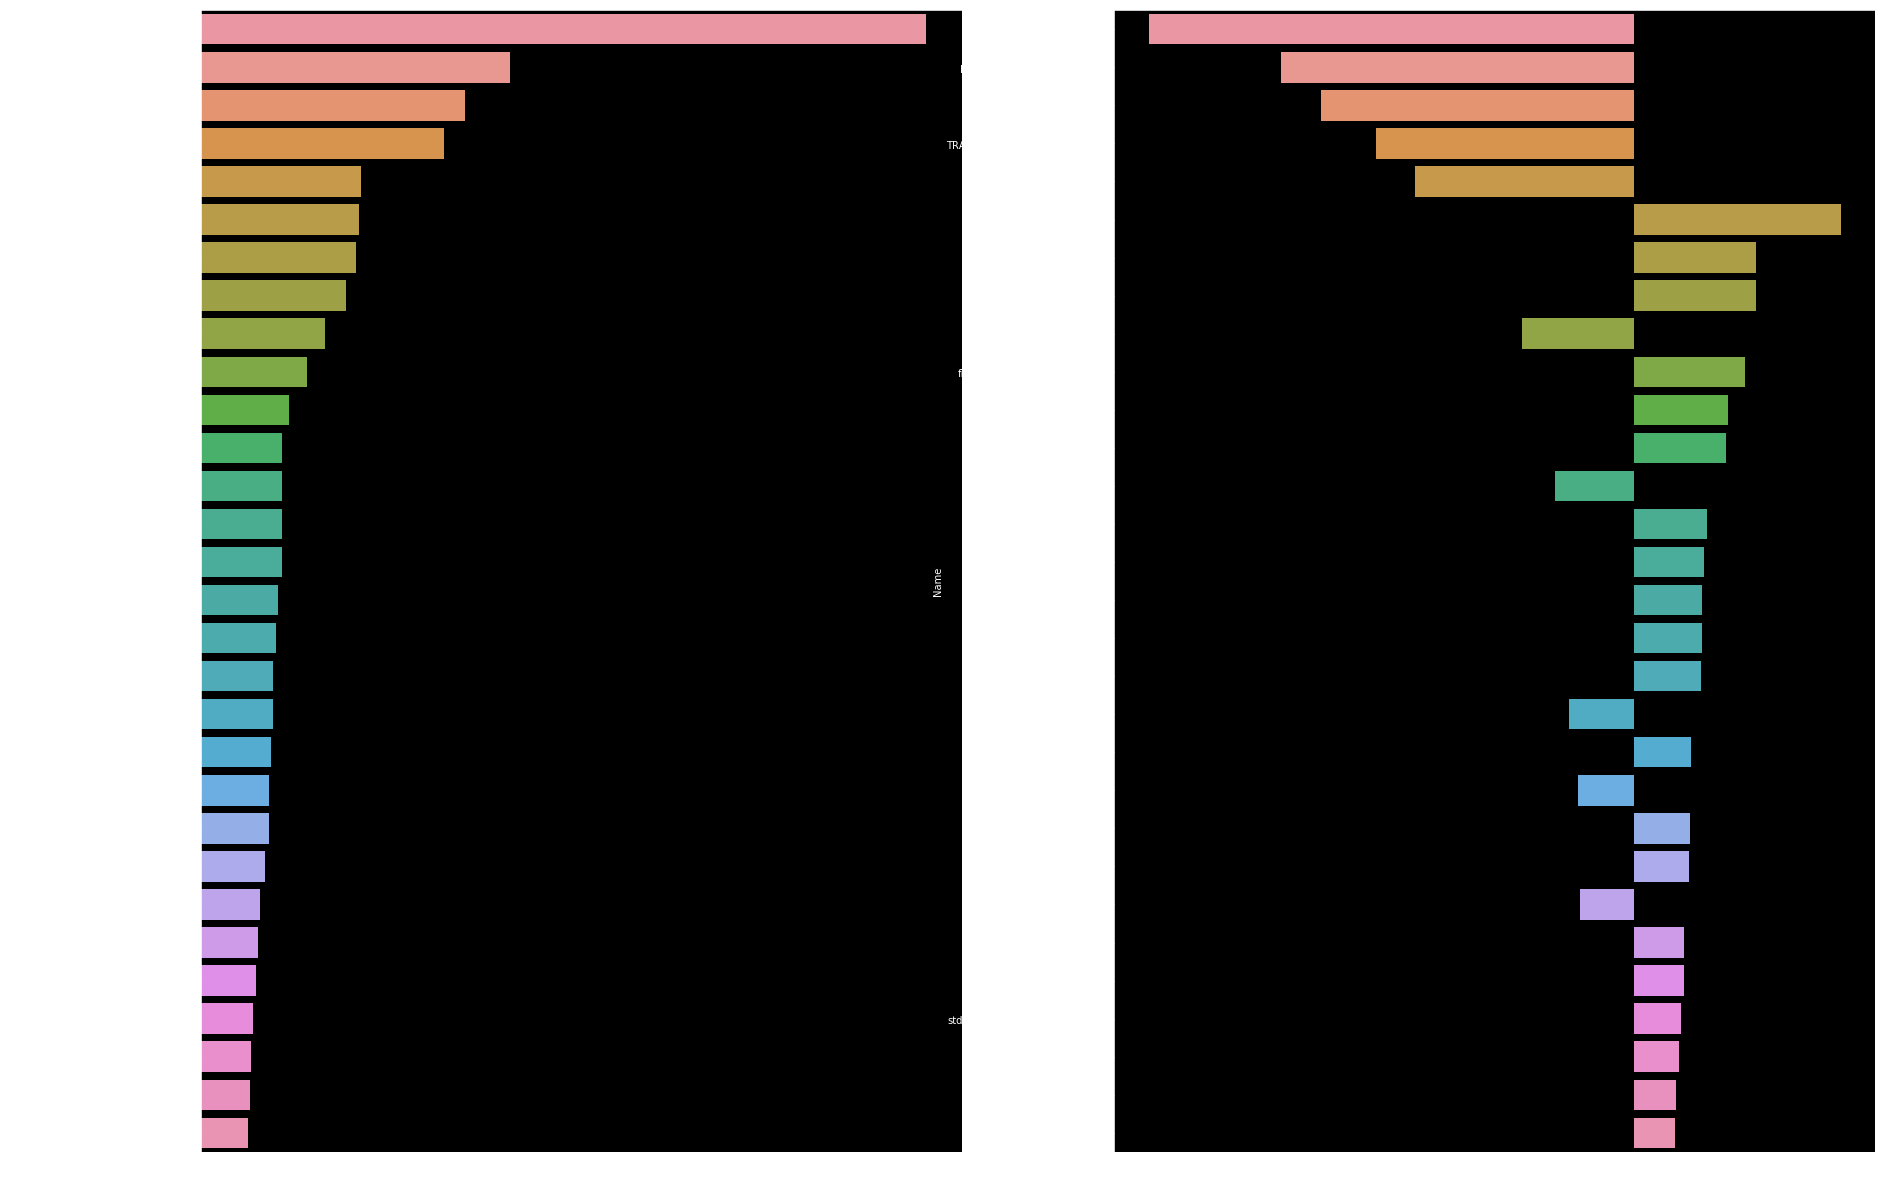

Wall time: 2min 17s


In [43]:
%%time
rocs = []
trees = []
feature_importances_split = []
feature_importances_shap = []
k_fold_predictions = []

X_meta = np.zeros((compl.shape[0],2))
X_meta[:X.shape[0],0]=y

kf = KFold(10,shuffle=True,random_state=seed)
for train_idx, val_idx in kf.split(X):

    X_tr = X.iloc[train_idx]
    y_tr = y.iloc[train_idx]
    X_val = X.iloc[val_idx]
    y_val = y.iloc[val_idx]

    cat_model = cb.CatBoostClassifier(**cat_params.copy())
    cat_model.fit(X=X_tr,y=y_tr,eval_set=(X_val,y_val),cat_features=index_cat,use_best_model=True)

    predict_tr = cat_model.predict(X_tr,prediction_type='Probability')[:,1]
    roc_auc_tr = roc_auc_score(y_tr,predict_tr)

    predict_val = cat_model.predict(X_val,prediction_type='Probability')[:,1]
    X_meta[val_idx,1]=predict_val

    roc_auc = roc_auc_score(y_val,predict_val)

    rocs.append(roc_auc)
    trees.append(cat_model.tree_count_)
    if len(cat_model.feature_importances_) == len(features):
        feature_importances_split.append(cat_model.feature_importances_)

    cp = cb.Pool(X_val,y_val,cat_features = index_cat)
    fi = cat_model.get_feature_importance(cp,fstr_type='ShapValues')[:,:-1]
    feature_importances_shap.append(fi)
    print('TRAIN:',roc_auc_tr,'VAL:',roc_auc)

clear_output()
avg_trees = sum(trees)//len(trees)
print(trees)
avg_roc = sum(rocs)/len(rocs)
print('Average ROC:',avg_roc,'Average trees:',avg_trees)

feature_importances_split = np.stack(feature_importances_split).mean(axis=0)
feature_importances_shap = (np.stack(feature_importances_shap).mean(axis=0)).mean(axis=0)
importances = pd.DataFrame({'Name':features,'Shap':list(feature_importances_shap),
                 'Split':list(feature_importances_split)})
importances['Shap_abs'] = np.abs(feature_importances_shap)
feature_sort = 'Split'
importances = importances.sort_values(feature_sort,ascending=False)
fig, ax = plt.subplots(figsize=(30,21),nrows=1,ncols=2)
sns.barplot(x=feature_sort, y='Name',data=importances[:30], ax=ax[0])
importances = importances.sort_values('Shap_abs',ascending=False)
sns.barplot(x='Shap', y='Name',data=importances[:30], ax=ax[1])
plt.show() 

In [44]:
cat_model = cat_model.fit(X=X,y=y,cat_features=index_cat)
start_pred = time.time()
predict_test = cat_model.predict(X_test,prediction_type='Probability')[:,1]
print((time.time()-start_pred))
test['Default'] = predict_test
X_meta[X.shape[0]:,1]=predict_test
test[['ID_CPTE','Default']].to_csv('SinglePredictions/'+f'{avg_roc:.5f}_'+'CB2_full.csv',index=False)
np.save('Stacksfull/'+f'{avg_roc:.5f}_'+'MetaCB2_full.npy',X_meta)

0.05715179443359375


In [45]:
print((time.time()-start))

216.13372707366943


In [46]:
len(features)

221